# Fourier continuations of third kind

This notebook implements Fourier continuations of the third kind with iterative refinement and overcollocation to decompose a non-periodic function into plane waves. It studies how to best carry out the periodic extension of an arbitrary, complex funtion.

### Start with decomposition into plane waves

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy 

In [2]:
def getFPICSUMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N), dtype=complex)
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.exp(1j * j * np.pi / theta * x[i])
    return M, x

def invertComplexM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape, dtype=complex)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T.conjugate() @ sinv @ U.T.conjugate()

Reproduce figure 8


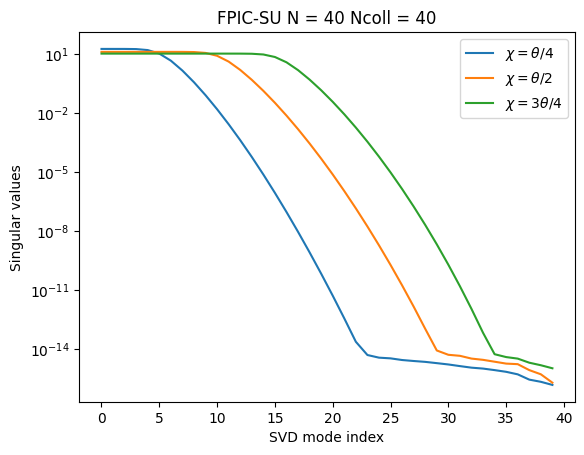

In [3]:

N     = 40
Ncoll = N

#The extended domain is split up into the physical and extension parts
#  [-theta, -chi, chi, theta]
theta = np.pi    # extension domain boundary
plt.title(f"FPIC-SU N = {N} Ncoll = {Ncoll}")
plt.ylabel("Singular values")
plt.xlabel("SVD mode index") 
plt.yscale("log") 

chis   = [theta/4, theta/2, 3*theta/4]  # physical domain boundary
labels = [r"$\chi = \theta/4$", r"$\chi = \theta/2$", r"$\chi = 3\theta/4$"]

for chi, label in zip(chis, labels): 
    M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
    y = scipy.linalg.svdvals(M, overwrite_a=False, check_finite=True)
    x = np.arange(len(y))
    plt.plot(x, y, label=label)
plt.legend()
plt.show()

Compute pseudoinverse of matrix using SVD:

For any matrix $M \in \mathbb{R}^{m\times n}$ , there exist orthogonal matrices $M \in \mathbb{R}^{m\times m}$ and $V \in \mathbb{R}^{n\times n}$ and scalars $σ_1 , . . . , σ_n$ such that
$$ M = U S V^T$$

In [36]:
chi = theta/2 

M, x = getFPICSUMatrix(N, Ncoll, theta, chi) 
#Factorizes the matrix a into two unitary matrices U and Vh, and a 1-D array s of singular values (real, non-negative) such that a == U @ S @ Vh, where S is a suitably shaped matrix of zeros with main diagonal s.
U, s, Vh = scipy.linalg.svd(M)

Compute pseudoinverse by inverting $S$ with cutoff

In [37]:


#Test implementation of invert M
A = np.random.rand(32, 32) + 1j * np.random.rand(32, 32)
np.testing.assert_allclose(np.abs(scipy.linalg.inv(A) - invertComplexM(A, 0)), 0, atol=1e-13)


Finally compute the periodic extension of an arbitrary complex function ($f(x) = e^x + i e^x $ in this example)

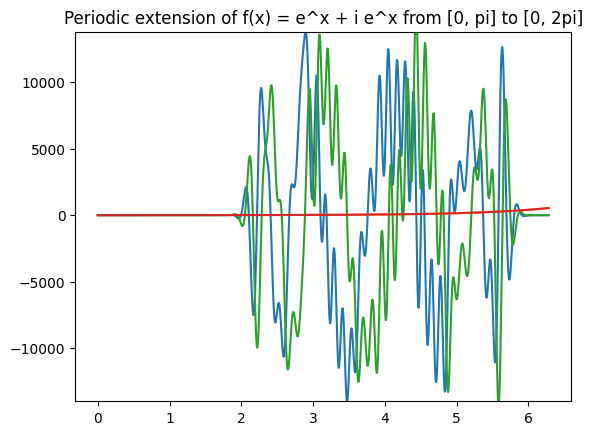

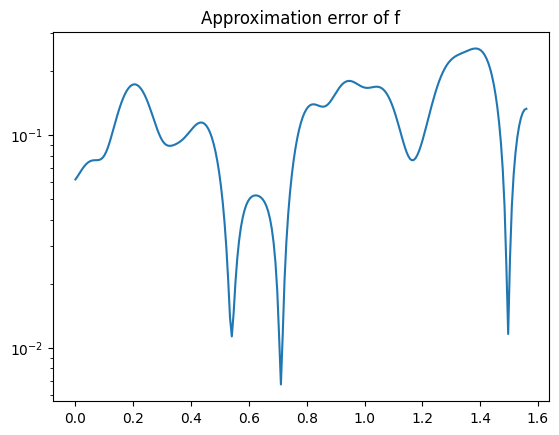

In [38]:
N     = 64
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

f     = func(x) 
Minv  = invertComplexM(M, 1e-14)
a     = Minv @ f

def reconstruct(x, a, theta): 
    rec = np.zeros(x.shape, dtype=complex) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.exp(1j * np.pi / theta * j * x)
    return rec

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

Improve this result by using iterative refinement

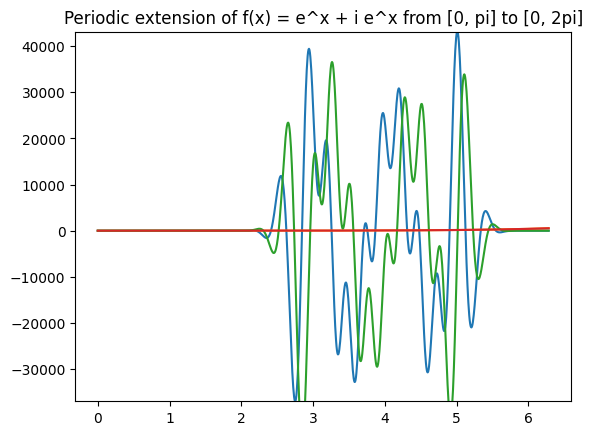

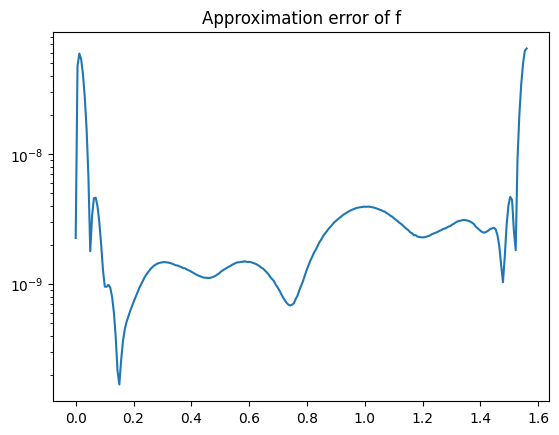

In [40]:
def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        counter += 1
    return a

N     = 32
Ncoll = N
theta = np.pi
chi   = theta/2 
M, x  = getFPICSUMatrix(N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

f     = func(x) 
Minv  = invertComplexM(M, 1e-14)
a     = iterativeRefinement(M, Minv, f, threshold = 10, maxiter = 3)

xext = np.linspace(0, 2*theta, 1000)
frec = reconstruct(xext, a, theta) 

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

We see that decomposition into plane waves works in principle but leads to very large function values in the extension domain, strong oscillatory behaviour and less than ideal reconstruction of the original function. 

### Can we get a better result by splitting everything into symmetric and antisymmetric parts and doing 4 real SVDs?

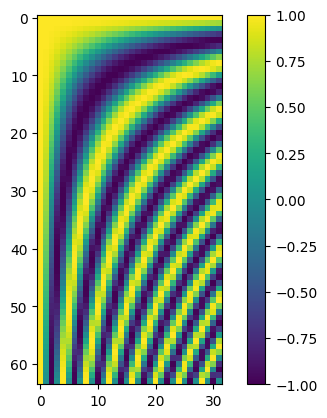

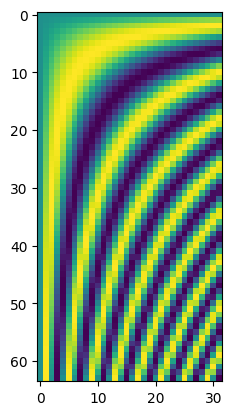

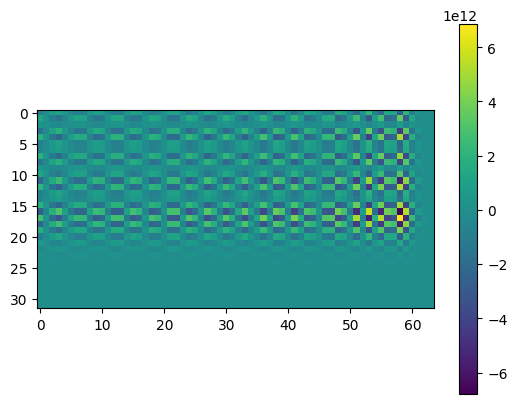

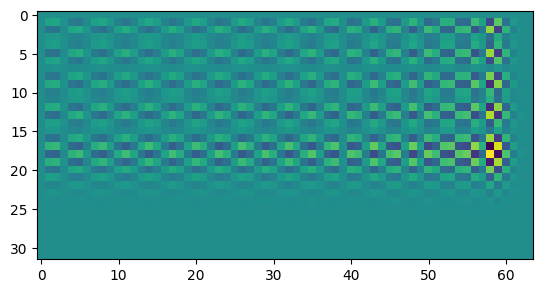

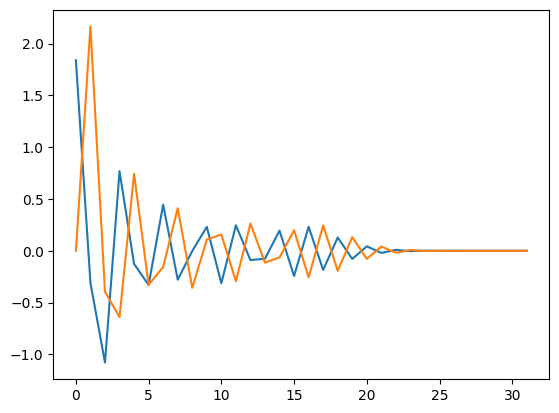

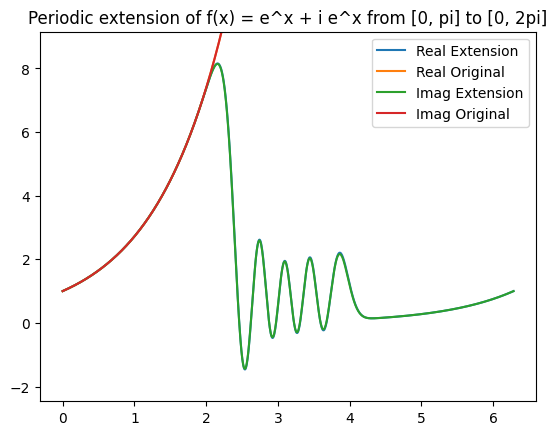

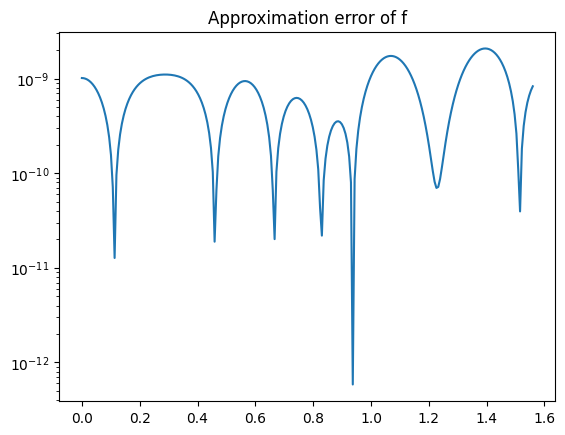

In [40]:
def getFPICSUEvenMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.cos(j * np.pi / theta * x[i])
    return M, x

def getFPICSUOddMatrix(N, Ncoll, theta, chi): 
    x = np.zeros(Ncoll)
    M = np.zeros((Ncoll, N))
    for i in range(Ncoll):
        for j in range(N):
            #Collocation points uniformly distributed over the positive half
            #of the physical interval x in [0, chi]
            x[i]    = i * chi / (Ncoll - 1) 
            M[i, j] = np.sin(j * np.pi / theta * x[i])
    return M, x

def invertRealM(M, cutoff):
    U, s, Vh = scipy.linalg.svd(M)
    sinv = np.zeros(M.T.shape)
    for i in range(np.min(M.shape)):
        if s[i] < cutoff:
            sinv[i, i] = 0
        else:
            sinv[i, i] = 1/s[i]
    return Vh.T @ sinv @ U.T


def reconstructOdd(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.sin(np.pi / theta * j * x)
    return rec

def reconstructEven(x, a, theta): 
    rec = np.zeros(x.shape) 
    for j, coeff in enumerate(a): 
        rec += coeff * np.cos(np.pi / theta * j * x)
    return rec

def iterativeRefinement(M, Minv, f, threshold = 100, maxiter = 5): 
    a       = Minv @ f
    r       = M @ a - f
    counter = 0
    while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
        delta    = Minv @ r
        a        = a - delta 
        r        = M @ a - f
        counter += 1
    return a


N     = 32
Ncoll = N * 2
theta = np.pi
chi   = theta/2 
Meven, x  = getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
Modd,  x  = getFPICSUOddMatrix (N, Ncoll, theta, chi) 

def func(x):
    return np.exp(x) + 1j * np.exp(x) 

Meveninv  = invertRealM(Meven, 1e-14)
Moddinv   = invertRealM(Modd,  1e-14)


plt.imshow(Meven)
plt.colorbar()
plt.show()
plt.imshow(Modd)
plt.show()
plt.imshow(Meveninv)
plt.colorbar()
plt.show()
plt.imshow(Moddinv)
plt.show()

xext = np.linspace(0, 2*theta, 1000)

f      = func(x)
feven  = (func(x) + func(-x)).real/2
fodd   = (func(x) - func(-x)).real/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 3)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 3)
plt.plot(aeven)
plt.plot(aodd)
plt.show()
freal  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta) 
feven  = (func(x) + func(-x)).imag/2
fodd   = (func(x) - func(-x)).imag/2
aeven  = iterativeRefinement(Meven, Meveninv, feven, threshold = 10, maxiter = 10)
aodd   = iterativeRefinement(Modd,  Moddinv,  fodd,  threshold = 10, maxiter = 10)
fimag  = reconstructOdd(xext, aodd, theta) + reconstructEven(xext, aeven, theta) 
frec   = freal + 1j * fimag

plt.title("Periodic extension of f(x) = e^x + i e^x from [0, pi] to [0, 2pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 
plt.title("Approximation error of f")
ul = np.argwhere(xext<chi)[-1][0]
xorg = xext[:ul]
plt.yscale("log")
plt.plot(xorg, np.abs(func(xorg) - frec[:ul]))
plt.show() 

## The all-in-one solution

In [216]:
class FourierExtension:
    def __init__(self, N, Ncoll, theta, chi, cutoff):
        self.N, self.Ncoll, self.theta, self.chi, self.cutoff = N, Ncoll, theta, chi, cutoff 
        self.Meven  = self.getFPICSUEvenMatrix(N, Ncoll, theta, chi) 
        self.Modd  = self.getFPICSUOddMatrix (N, Ncoll, theta, chi) 

        self.dx    = chi / (Ncoll - 1) 
        self.x     = np.arange(-Ncoll + 1, Ncoll) * self.dx


        self.Meveninv  = self.invertRealM(self.Meven, cutoff)
        self.Moddinv   = self.invertRealM(self.Modd,  cutoff)

    def getX(self): 
        return self.x, self.dx
    
    def getFPICSUEvenMatrix(self, N, Ncoll, theta, chi): 
        M  = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.cos(j * np.pi / theta * i * dx)
        return M

    def getFPICSUOddMatrix(self, N, Ncoll, theta, chi): 
        M = np.zeros((Ncoll, N))
        dx = chi / (Ncoll - 1) 
        for i in range(Ncoll):
            for j in range(N):
                #Collocation points uniformly distributed over the positive half
                #of the physical interval x in [0, chi]
                M[i, j] = np.sin(j * np.pi / theta * i * dx)
        return M

    def invertRealM(self, M, cutoff):
        U, s, Vh = scipy.linalg.svd(M)
        sinv = np.zeros(M.T.shape)
        for i in range(np.min(M.shape)):
            if s[i] < cutoff:
                sinv[i, i] = 0
            else:
                sinv[i, i] = 1/s[i]
        return Vh.T @ sinv @ U.T


    def reconstructOdd(self, x, a, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, coeff in enumerate(a): 
            rec += coeff * np.sin(np.pi / theta * j * x)
        return rec

    def reconstructEven(self, x, a, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, coeff in enumerate(a): 
            rec += coeff * np.cos(np.pi / theta * j * x)
        return rec
    
    def reconstruct(self, x, aodd, aeven, theta): 
        rec = np.zeros(x.shape, dtype=complex) 
        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)): 
            rec += ( evecoeff / ( 2 * 1 ) + oddcoeff / ( 2 * 1j ) ) * ( np.exp(+ 1j * np.pi / theta * j * x) )
        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)): 
            rec += ( evecoeff / ( 2 * 1 ) - oddcoeff / ( 2 * 1j ) ) * ( np.exp(- 1j * np.pi / theta * j * x) )
        return rec
    
    def convertToFourierCoeff(self, aodd, aeven):
        k = np.arange(-self.N+1, self.N) * np.pi / self.theta
        fhat = np.zeros(2*self.N-1, dtype=complex)

        for j, (oddcoeff, evecoeff) in enumerate(zip(aodd, aeven)):
            fhat[ j + self.N - 1] +=   oddcoeff / (2j) + evecoeff / (2)
            fhat[-j + self.N - 1] += - oddcoeff / (2j) + evecoeff / (2)


        return fhat, k

    def reconstructFourier(self, x, fhat): 
        rec  = np.zeros (   x.shape, dtype=complex) 
        ks   = np.arange( -self.N+1, self.N) * np.pi / self.theta
        for k, coeff in zip(ks, fhat): 
            rec += coeff * np.exp(1j * k * x)
        return rec
    
    def iterativeRefinement(self, M, Minv, f, threshold = 100, maxiter = 5): 
        a       = Minv @ f
        r       = M @ a - f
        counter = 0
        while np.linalg.norm(r) > 100 * np.finfo(float).eps * np.linalg.norm(a) and counter < maxiter: 
            delta    = Minv @ r
            a        = a - delta 
            r        = M @ a - f
            counter += 1
        return a

    def computePeriodicExtension(self, f, xext, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        frec     = self.reconstruct(xext, aodd, aeven, self.theta)
        return frec
    
    def computePeriodicFourierExtension(self, f, xext, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        #frec     = self.reconstructOdd(xext, aodd, self.theta) + self.reconstructEven(xext, aeven, self.theta) 
        fhat, k  = self.convertToFourierCoeff(aodd, aeven) 
        frec     = self.reconstructFourier(xext, fhat) 
        return frec, fhat
    
    def computeExtension(self, f, Ni, threshold = 10, maxiter = 3): 
        refeven  = ((f + np.flip(f)).real/2)[self.Ncoll-1:]
        refodd   = ((f - np.flip(f)).real/2)[self.Ncoll-1:]
        imfeven  = ((f + np.flip(f)).imag/2)[self.Ncoll-1:]
        imfodd   = ((f - np.flip(f)).imag/2)[self.Ncoll-1:]
        aeven    = self.iterativeRefinement(self.Meven, self.Meveninv, refeven, threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Meven, self.Meveninv, imfeven, threshold = threshold, maxiter = maxiter)
        aodd     = self.iterativeRefinement(self.Modd,  self.Moddinv,  refodd,  threshold = threshold, maxiter = maxiter) + 1j * self.iterativeRefinement(self.Modd,  self.Moddinv,  imfodd,  threshold = threshold, maxiter = maxiter)
        #frec     = self.reconstructOdd(xext, aodd, self.theta) + self.reconstructEven(xext, aeven, self.theta) 
        fhat, k  = self.convertToFourierCoeff(aodd, aeven) 
        fhat     = np.fft.ifftshift(np.pad(fhat, (1, 0), mode="constant"))
        frec     = self.fourierInterpolation(fhat, Ni)
        return frec, fhat
    
    def plotApproximationErorr(self, func, frec, xext):
        plt.title("Approximation error of f")
        #First index where xext is greather than - chi 
        ul = np.argwhere(xext>-chi)[ 0][0]
        #Last index where xext is smaller than + chi
        uh = np.argwhere(xext<chi)[-1][0]
        
        xorg = xext[ul:uh]
        plt.yscale("log")
        plt.plot(xorg, np.abs(func(xorg) - frec[ul:uh]))
        plt.show() 

    def fourierInterpolation(self, fhat, Ni):
        N = len(fhat) 
        Npad = int(Ni/2 - N/2) 
        ft   = np.fft.fftshift(fhat)
        ft_pad = np.concatenate([np.zeros(Npad), ft, np.zeros(Npad)])
        fint = scipy.fft.ifft(np.fft.fftshift(ft_pad), norm="forward")
        return fint

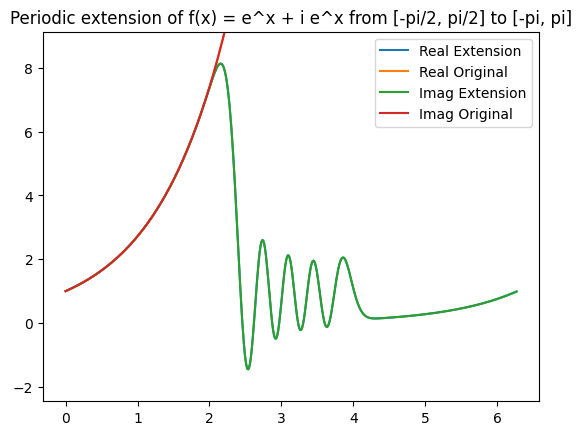

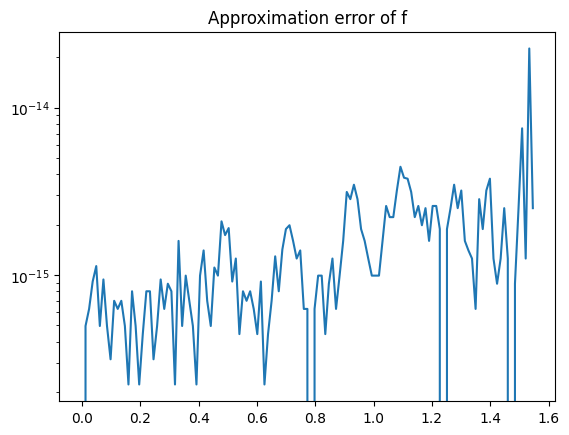

In [222]:
N     = 32
Ncoll = N * 2
theta = np.pi 
chi   = theta/2 
cutoff = 1e-14
def func(x):
    return np.exp(x) + 1j * np.exp(x) 

fext = FourierExtension( N, Ncoll, theta, chi, cutoff = cutoff)
x, dx = fext.getX()
f = func(x)
Ni = 512
xext = np.linspace(0, 2*theta, Ni+1)[:-1]

frec, fhat = fext.computeExtension(f, Ni, maxiter=10)

plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-pi, pi]")
plt.plot(xext, frec.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 

fext.plotApproximationErorr(func, frec, xext)

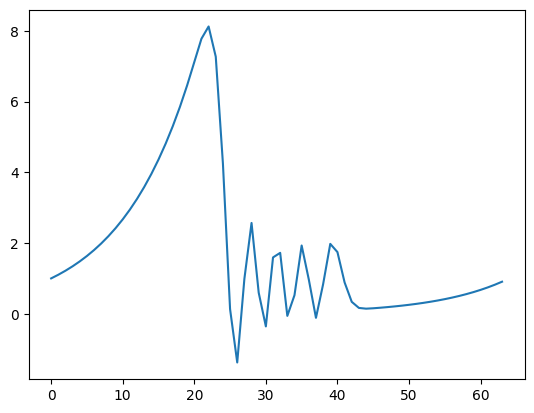

In [186]:


f2 = scipy.fft.ifft(fhat, norm="forward")
plt.plot(f2.real)

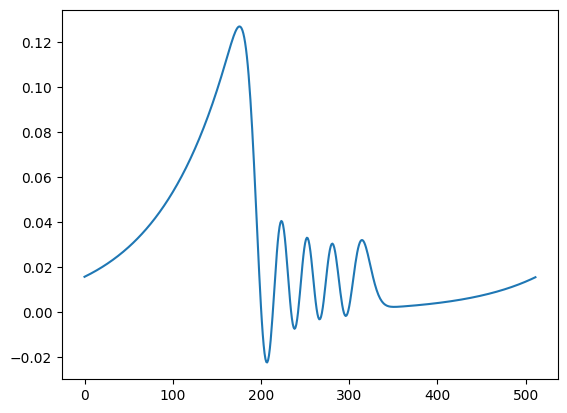

In [189]:


plt.plot(fourierInterpolation(fhat, 512).real)

Positive coeff j = 0 = (0.9163923422456719+0.9163923422456719j) with k = 0.0
Negative coeff j = 0 = (1.8327846844913438+1.8327846844913438j) with k = 0.0
Positive coeff j = 1 = (0.9292472908869556-1.2353875077110885j) with k = 1.0
Negative coeff j = 1 = (-1.2353875077110885+0.9292472908869556j) with k = -1.0
Positive coeff j = 2 = (-0.7302372449775589-0.33484998788486564j) with k = 2.0
Negative coeff j = 2 = (-0.33484998788486564-0.7302372449775589j) with k = -2.0
Positive coeff j = 3 = (0.05069047831268847+0.6899717652537873j) with k = 3.0
Negative coeff j = 3 = (0.6899717652537873+0.05069047831268847j) with k = -3.0
Positive coeff j = 4 = (0.3234504554279951-0.41880161092606016j) with k = 4.0
Negative coeff j = 4 = (-0.41880161092606016+0.3234504554279951j) with k = -4.0
Positive coeff j = 5 = (-0.33943670624469746-0.012176032932956105j) with k = 5.0
Negative coeff j = 5 = (-0.012176032932956105-0.33943670624469746j) with k = -5.0
Positive coeff j = 6 = (0.14639681712730024+0.3040856

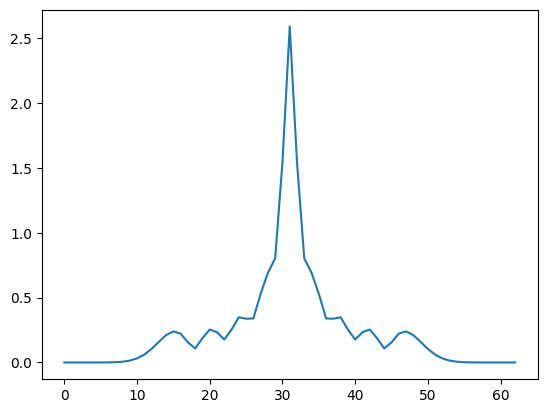

In [164]:
aodd, aeven = fext.computePeriodicFourierExtension(f, xext)
fhat, k = fext.convertToFourierCoeff(aodd, aeven)
plt.plot(np.abs(fhat))
plt.show()

In [166]:
frec2 = fext.reconstructFourier(xext, fhat)


k = -31.0 coeff = (-2.521564704152314e-09+1.8166516317943317e-09j)
k = -29.999999999999996 coeff = (5.7499333311992616e-08-3.979106179617762e-08j)
k = -29.0 coeff = (-6.626153547743124e-07+4.400346080516565e-07j)
k = -28.0 coeff = (5.128588625030739e-06-3.262791486907668e-06j)
k = -27.0 coeff = (-2.9899537204482185e-05+1.817799131590553e-05j)
k = -26.000000000000004 coeff = (0.00013961613750956836-8.084241641603818e-05j)
k = -25.0 coeff = (-0.0005421871887910656+0.0002976634882606577j)
k = -24.0 coeff = (0.0017950025876631859-0.0009288312494606377j)
k = -23.0 coeff = (-0.005152526609980335+0.0024931470325997296j)
k = -21.999999999999996 coeff = (0.01297219677441852-0.005806387263211477j)
k = -21.0 coeff = (-0.028857559284762857+0.01176773360824157j)
k = -20.0 coeff = (0.05694035530138564-0.020679810862539227j)
k = -19.0 coeff = (-0.09967002479259435+0.031086975679663453j)
k = -18.0 coeff = (0.1540932044960357-0.03864284589568001j)
k = -17.0 coeff = (-0.20803999587009514+0.0361820964659

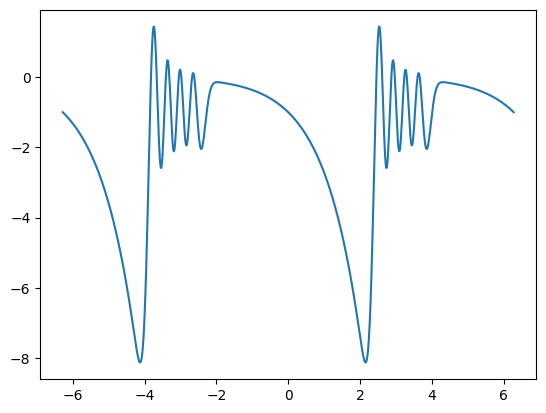

In [167]:
plt.plot(xext, -frec2.real)

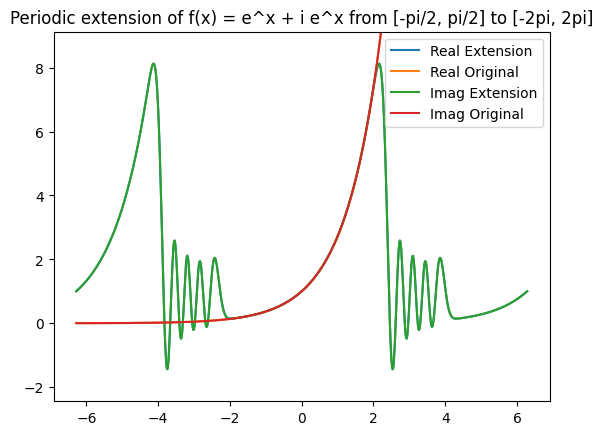

In [168]:

plt.title("Periodic extension of f(x) = e^x + i e^x from [-pi/2, pi/2] to [-2pi, 2pi]")
plt.plot(xext, frec2.real,       label="Real Extension") 
plt.plot(xext, func(xext).real, label="Real Original") 
plt.plot(xext, frec2.imag,       label="Imag Extension") 
plt.plot(xext, func(xext).imag, label="Imag Original") 
plt.legend()
plt.ylim(np.min(frec) - 1, np.max(frec) + 1)
plt.show() 